In [1]:
import torch
from PIL import Image

from colpali_engine.models import ColQwen2, ColQwen2Processor

model_name = "/ivi/ilps/personal/jqiao/models/Qwen2-VL-2B-Instruct"

model = ColQwen2.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # or "mps" if on Apple Silicon
).eval()

processor = ColQwen2Processor.from_pretrained(model_name)

# Your inputs
images = [
    Image.new("RGB", (32, 32), color="white"),
    Image.new("RGB", (16, 16), color="black"),
]
queries = [
    "Is attention really all you need?",
    "Are Benjamin, Antoine, Merve, and Jo best friends?",
]

# Process the inputs
batch_images = processor.process_images(images).to(model.device)
batch_queries = processor.process_queries(queries).to(model.device)

# Forward pass
with torch.no_grad():
    image_embeddings = model(**batch_images)
    query_embeddings = model(**batch_queries)

print("query_embeddings ", query_embeddings)
print("image_embeddings ", image_embeddings)

scores = processor.score_multi_vector(query_embeddings, image_embeddings)

print("scores ", scores)

/ivi/ilps/personal/jqiao/anaconda3/envs/colpali/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards:   0%|          | 0/2 [00:18<?, ?it/s]


RuntimeError: No CUDA GPUs are available

In [ ]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from einops import rearrange
from PIL import Image
from typing import List, Tuple, Union

import torch
from einops import rearrange

EPSILON = 1e-10

def get_similarity_maps_from_embeddings(
    image_embeddings: torch.Tensor,
    query_embeddings: torch.Tensor,
    n_patches: Union[Tuple[int, int], List[Tuple[int, int]]],
    image_mask: torch.Tensor,
) -> List[torch.Tensor]:
    """
    Get the batched similarity maps between the query embeddings and the image embeddings.
    Each element in the returned list is a tensor of shape (query_tokens, n_patches_x, n_patches_y).
    Args:
        image_embeddings: tensor of shape (batch_size, image_tokens, dim)
        query_embeddings: tensor of shape (batch_size, query_tokens, dim)
        n_patches: number of patches per dimension for each image in the batch. If a single tuple is provided,
            the same number of patches is used for all images in the batch (broadcasted).
        image_mask: tensor of shape (batch_size, image_tokens). Used to filter out the embeddings
            that are not related to the image
    """

    if isinstance(n_patches, tuple):
        n_patches = [n_patches] * image_embeddings.size(0)

    similarity_maps: List[torch.Tensor] = []

    for idx in range(image_embeddings.size(0)):
        # Sanity check
        if image_mask[idx].sum() != n_patches[idx][0] * n_patches[idx][1]:
            raise ValueError(
                f"The number of patches ({n_patches[idx][0]} x {n_patches[idx][1]} = "
                f"{n_patches[idx][0] * n_patches[idx][1]}) "
                f"does not match the number of non-padded image tokens ({image_mask[idx].sum()})."
            )

        # Rearrange the output image tensor to explicitly represent the 2D grid of patches
        image_embedding_grid = rearrange(
            image_embeddings[idx][image_mask[idx]],  # (n_patches_x * n_patches_y, dim)
            "(h w) c -> w h c",
            w=n_patches[idx][0],
            h=n_patches[idx][1],
        )  # (n_patches_x, n_patches_y, dim)

        similarity_map = torch.einsum(
            "nk,ijk->nij", query_embeddings[idx], image_embedding_grid
        )  # (batch_size, query_tokens, n_patches_x, n_patches_y)

        similarity_maps.append(similarity_map)

    return similarity_maps

def normalize_similarity_map(similarity_map: torch.Tensor) -> torch.Tensor:
    """
    Normalize the similarity map to have values in the range [0, 1].

    Args:
        similarity_map: tensor of shape (n_patch_x, n_patch_y) or (batch_size, n_patch_x, n_patch_y)
    """
    if similarity_map.ndim not in [2, 3]:
        raise ValueError(
            "The input tensor must have 2 dimensions (n_patch_x, n_patch_y) or "
            "3 dimensions (batch_size, n_patch_x, n_patch_y)."
        )

    # Compute the minimum values along the last two dimensions (n_patch_x, n_patch_y)
    min_vals = similarity_map.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]  # (1, 1) or (batch_size, 1, 1)

    # Compute the maximum values along the last two dimensions (n_patch_x, n_patch_y)
    max_vals = similarity_map.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]  # (1, 1) or (batch_size, 1, 1)

    # Normalize the tensor
    # NOTE: Add a small epsilon to avoid division by zero.
    similarity_map_normalized = (similarity_map - min_vals) / (
        max_vals - min_vals + EPSILON
    )  # (n_patch_x, n_patch_y) or (batch_size, n_patch_x, n_patch_y)

    return similarity_map_normalized

def plot_similarity_map(
    image: Image.Image,
    similarity_map: torch.Tensor,
    figsize: Tuple[int, int] = (8, 8),
    show_colorbar: bool = False,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot and overlay a similarity map over the input image.

    A similarity map is a 2D tensor where each element (i, j) represents the similarity score between a chosen query
    token and the associated image patch at position (i, j). Thus, the higher the similarity score, the brighter the
    color of the patch.

    To show the returned similarity map, use:

    ```python
    >>> fig, ax = plot_similarity_map(image, similarity_map)
    >>> fig.show()
    ```

    Args:
        image: PIL image
        similarity_map: tensor of shape (n_patches_x, n_patches_y)
        figsize: size of the figure
        show_colorbar: whether to show a colorbar
    """

    # Convert the image to an array
    img_array = np.array(image.convert("RGBA"))  # (height, width, channels)

    # Normalize the similarity map and convert it to Pillow image
    similarity_map_array = (
        normalize_similarity_map(similarity_map).to(torch.float32).cpu().numpy()
    )  # (n_patches_x, n_patches_y)

    # Reshape the similarity map to match the PIL shape convention
    similarity_map_array = rearrange(similarity_map_array, "h w -> w h")  # (n_patches_y, n_patches_x)

    similarity_map_image = Image.fromarray((similarity_map_array * 255).astype("uint8")).resize(
        image.size, Image.Resampling.BICUBIC
    )

    # Create the figure
    with plt.style.context("dark_background"):
        fig, ax = plt.subplots(figsize=figsize)

        ax.imshow(img_array)
        im = ax.imshow(
            similarity_map_image,
            cmap=sns.color_palette("mako", as_cmap=True),
            alpha=0.5,
        )

        if show_colorbar:
            fig.colorbar(im)
        ax.set_axis_off()
        fig.tight_layout()

    return fig, ax


def plot_all_similarity_maps(
    image: Image.Image,
    query_tokens: List[str],
    similarity_maps: torch.Tensor,
    figsize: Tuple[int, int] = (8, 8),
    show_colorbar: bool = False,
    add_title: bool = True,
) -> List[Tuple[plt.Figure, plt.Axes]]:
    """
    For each token in the query, plot and overlay a similarity map over the input image.

    A similarity map is a 2D tensor where each element (i, j) represents the similarity score between a chosen query
    token and the associated image patch at position (i, j). Thus, the higher the similarity score, the brighter the
    color of the patch.

    Args:
        image: PIL image
        query_tokens: list of query tokens
        similarity_maps: tensor of shape (query_tokens, n_patches_x, n_patches_y)
        figsize: size of the figure
        show_colorbar: whether to show a colorbar
        add_title: whether to add a title with the token and the max similarity score

    """

    plots: List[Tuple[plt.Figure, plt.Axes]] = []

    for idx, token in enumerate(query_tokens):
        fig, ax = plot_similarity_map(
            image=image,
            similarity_map=similarity_maps[idx],
            figsize=figsize,
            show_colorbar=show_colorbar,
        )

        if add_title:
            max_sim_score = similarity_maps[idx].max().item()
            # ax.set_title(f"Token #{idx}: `{token}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)
            ax.set_title(f"Token #{idx}: `{token}`. MaxSim score: {max_sim_score:.2f}", fontsize=14, y=0.8)  # y=0.9 positions the title inside the upper part of the image

        plots.append((fig, ax))

    return plots

# from 151643 to 151655

In [2]:
batch_images = {'input_ids': [[151644,    872,    198, 151652, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151653,  74785,    279,   2168,     13, 151645, 151643]]}

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/ivi/ilps/personal/jqiao/models/Qwen2-VL-2B-Instruct")
tokenizer.convert_ids_to_tokens(batch_images['input_ids'][0])

/ivi/ilps/personal/jqiao/anaconda3/envs/colpali/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokens = [
    '<|im_start|>', 'user', 'Ċ', '<|vision_start|>',
    '<|image_pad|>', '<|image_pad|>', '<|image_pad|>',
    '<|vision_end|>', 'Describe', 'Ġthe', 'Ġimage', '.', 
    '<|im_end|>', '<|endoftext|>'
]

def add_index_for_patch(tokens):
    pad_index = 0
    new_tokens = []
    # Loop through the tokens and replace <|image_pad|> with the current index
    for token in tokens:
        if token == '<|image_pad|>':
            new_tokens.append(str(pad_index))
            pad_index += 1
        else:
            new_tokens.append(token)
    return new_tokens

# Print the new list of tokens
add_index_for_patch(tokens)


['<|im_start|>',
 'user',
 'Ċ',
 '<|vision_start|>',
 '0',
 '1',
 '2',
 '<|vision_end|>',
 'Describe',
 'Ġthe',
 'Ġimage',
 '.',
 '<|im_end|>',
 '<|endoftext|>']

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
from typing import List, Tuple, Optional,Union

def get_similarity_maps_from_embeddings(
    image_embeddings: torch.Tensor,
    query_embeddings: torch.Tensor,
    n_patches: Union[Tuple[int, int], List[Tuple[int, int]]]
) -> List[torch.Tensor]:
    """
    Get the batched similarity maps between the query embeddings and the image embeddings.
    Each element in the returned list is a tensor of shape (query_tokens, n_patches_x, n_patches_y).

    Args:
        image_embeddings: tensor of shape (batch_size, image_tokens, dim)
        query_embeddings: tensor of shape (batch_size, query_tokens, dim)
        n_patches: number of patches per dimension for each image in the batch. If a single tuple is provided,
            the same number of patches is used for all images in the batch (broadcasted).
    """

    if isinstance(n_patches, tuple):
        n_patches = [n_patches] * image_embeddings.size(0)

    similarity_maps: List[torch.Tensor] = []

    for idx in range(image_embeddings.size(0)):
        # Assuming all tokens are valid, skip any mask-based filtering.
        image_embedding_grid = rearrange(
            image_embeddings[idx],  # Use all tokens directly
            "(h w) c -> w h c",
            w=n_patches[idx][0],
            h=n_patches[idx][1],
        )  # (n_patches_x, n_patches_y, dim)

        similarity_map = torch.einsum(
            "nk,ijk->nij", query_embeddings[idx], image_embedding_grid
        )  # (query_tokens, n_patches_x, n_patches_y)
        similarity_maps.append(similarity_map)

    return similarity_maps

n_patches = (24,31)
# Generate a dummy image (you would replace this with your actual image data)
image = np.random.rand(n_patches[1], n_patches[0])

# Assuming you already have your similarity maps calculated
similarity_maps = get_similarity_maps_from_embeddings(image_embeddings, query_embeddings, (24, 31))

# Select the first similarity map from the first query (adjust indices as needed)
similarity_map = similarity_maps[0].squeeze()  # remove batch dimension if necessary

# Normalize the similarity map for better visualization
normalized_map = (similarity_map - similarity_map.min()) / (similarity_map.max() - similarity_map.min())

# Create a figure to display the image and the overlay
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image, cmap='gray', interpolation='nearest')  # Display the image
ax.imshow(normalized_map, cmap='hot', alpha=0.5, interpolation='nearest')  # Overlay the similarity map with transparency
ax.set_title('Image with Similarity Map Overlay')
plt.show()


NameError: name 'image_embeddings' is not defined

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from einops import rearrange
from typing import List, Tuple, Union

def get_similarity_maps_from_embeddings(
    image_embeddings: torch.Tensor,
    query_embeddings: torch.Tensor,
    n_patches: Union[Tuple[int, int], List[Tuple[int, int]]]
) -> List[torch.Tensor]:
    """
    Get the batched similarity maps between the query embeddings and the image embeddings.
    Each element in the returned list is a tensor of shape (query_tokens, n_patches_x, n_patches_y).
    """
    if isinstance(n_patches, tuple):
        n_patches = [n_patches] * image_embeddings.size(0)

    similarity_maps: List[torch.Tensor] = []

    for idx in range(image_embeddings.size(0)):
        # Rearrange the image embeddings into a 2D grid of patches
        image_embedding_grid = rearrange(
            image_embeddings[idx], 
            "(h w) c -> h w c",
            h=n_patches[idx][1],
            w=n_patches[idx][0]
        )
        similarity_map = torch.einsum("nk,ijk->nij", query_embeddings[idx], image_embedding_grid)
        similarity_maps.append(similarity_map)

    return similarity_maps

# Dimensions
dim = 1536
n_patches = (24, 31)
num_query_tokens = 10
batch_size = 1
# Create random embeddings
image_embeddings = torch.rand(batch_size, dim)
query_embeddings = torch.rand(batch_size, dim)

print(image_embeddings, image_embeddings.shape)
print(query_embeddings, query_embeddings.shape)

# Calculate similarity maps
similarity_maps = get_similarity_maps_from_embeddings(image_embeddings, query_embeddings, n_patches)

# Visualization
similarity_map = similarity_maps[0].squeeze(0)  # Remove batch dimension

# Normalize the similarity map for better visualization
normalized_map = (similarity_map - similarity_map.min()) / (similarity_map.max() - similarity_map.min())

# Generate a dummy image
image = np.random.rand(n_patches[1], n_patches[0])

# Create a figure to display the image and the overlay
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image, cmap='gray', interpolation='nearest')  # Display the image
ax.set_title('Image with Similarity Map Overlay')
plt.show()


tensor([[0.9805, 0.7359, 0.3176,  ..., 0.5453, 0.3228, 0.8349]]) torch.Size([1, 1536])
tensor([[0.3551, 0.8772, 0.6608,  ..., 0.3480, 0.7313, 0.1329]]) torch.Size([1, 1536])


EinopsError:  Error while processing rearrange-reduction pattern "(h w) c -> h w c".
 Input tensor shape: torch.Size([1536]). Additional info: {'h': 31, 'w': 24}.
 Wrong shape: expected 2 dims. Received 1-dim tensor.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Sample embeddings
query_embedding = torch.randn(1, 1536)  # Random query embedding
image_embedding = torch.randn(1, 1536)  # Random image embedding

# Calculate cosine similarity
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
similarity = cos(query_embedding, image_embedding)

# Assuming the image size should be reshaped to (32, 48) for example
similarity_reshaped = similarity.view(32, 48).detach().numpy()

# Normalize the similarity scores for better visualization
normalized_similarity = (similarity_reshaped - np.min(similarity_reshaped)) / (np.max(similarity_reshaped) - np.min(similarity_reshaped))

# Generate a dummy image for demonstration (you would use the actual image here)
dummy_image = torch.rand(32, 48, 3)  # Creating a random image
pil_image = to_pil_image(dummy_image)

# Create a heatmap from the similarity scores
plt.imshow(pil_image)
plt.imshow(normalized_similarity, cmap='jet', alpha=0.5)  # Overlaying the heatmap with transparency
plt.colorbar()  # Show the color scale
plt.show()


RuntimeError: shape '[32, 48]' is invalid for input of size 1

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Example data: Let's assume you have 1536 embeddings for different regions of an image
query_embedding = torch.randn(1, 1536)  # Random query embedding
image_embeddings = torch.randn(1536, 1536)  # Random image embeddings for each region

# Calculate cosine similarity
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
similarities = cos(query_embedding.expand_as(image_embeddings), image_embeddings)

# Assume the image is divided into a grid, say 32x48 regions
similarities_reshaped = similarities.view(32, 48).detach().numpy()

# Normalize the similarity scores for better visualization
normalized_similarity = (similarities_reshaped - np.min(similarities_reshaped)) / (np.max(similarities_reshaped) - np.min(similarities_reshaped))

# Generate a dummy image for demonstration (you would use the actual image here)
dummy_image = torch.rand(32, 48, 3)  # Creating a random image
pil_image = to_pil_image(dummy_image)

# Create a heatmap from the similarity scores
plt.imshow(pil_image)
plt.imshow(normalized_similarity, cmap='jet', alpha=0.5)  # Overlaying the heatmap with transparency
plt.colorbar()  # Show the color scale
plt.show()


ValueError: pic should not have > 4 channels. Got 32 channels.

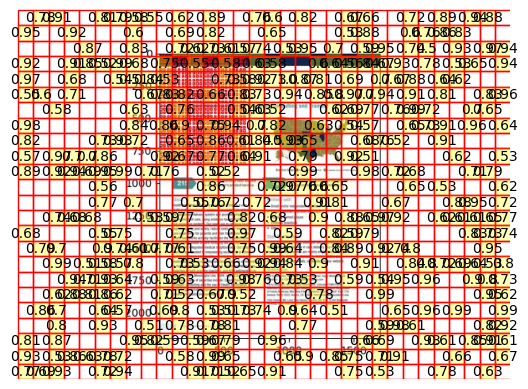

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def plot_similarity_on_image(image_path, sim_values, patches_horizontal, patches_vertical, threshold=0.5):
    # Load the image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Convert sim_values into a 2D array (reshape if necessary)
    sim_array = np.array(sim_values).reshape((patches_vertical, patches_horizontal))

    # Create a figure and axis for drawing
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Calculate patch size
    patch_width = img_width / patches_horizontal
    patch_height = img_height / patches_vertical

    # Create a patch grid and highlight based on threshold
    for i in range(patches_vertical):
        for j in range(patches_horizontal):
            # Create a rectangle patch
            rect = patches.Rectangle((j*patch_width, i*patch_height), patch_width, patch_height,
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            # Highlight patches above a certain threshold
            if sim_array[i, j] > threshold:
                highlight = patches.Rectangle((j*patch_width, i*patch_height), patch_width, patch_height,
                                              linewidth=1, edgecolor='r', facecolor='yellow', alpha=0.3)
                ax.add_patch(highlight)
                
                # Optionally add text inside the patch
                ax.text(j*patch_width + patch_width/2, i*patch_height + patch_height/2, str(round(sim_array[i, j], 2)),
                        color='black', ha='center', va='center')

    # Display the plot
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

# Example usage
similarity_values = np.random.rand(24 * 32)  # Example: 24 rows and 32 columns
plot_similarity_on_image('/ivi/ilps/personal/jqiao/colpali/patch_img.jpg', similarity_values, 32, 24, threshold=0.5)
